<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

In [ ]:
#|eval: false
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.testing as testing
from darts import TimeSeries
from darts.datasets import AirPassengersDataset

<Axes: xlabel='Month'>

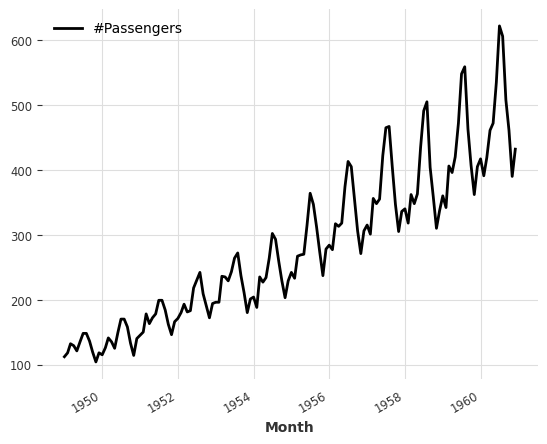

In [ ]:
#|eval: false
series = AirPassengersDataset().load()
series.plot()

<Axes: xlabel='Month'>

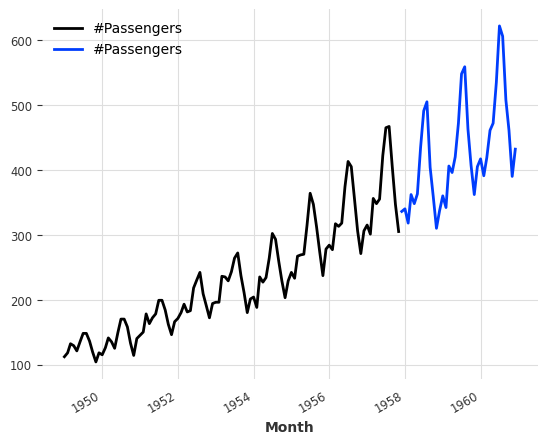

In [ ]:
#|eval: false
series1, series2 = series.split_before(0.75)
series1.plot()
series2.plot()

<Axes: xlabel='Month'>

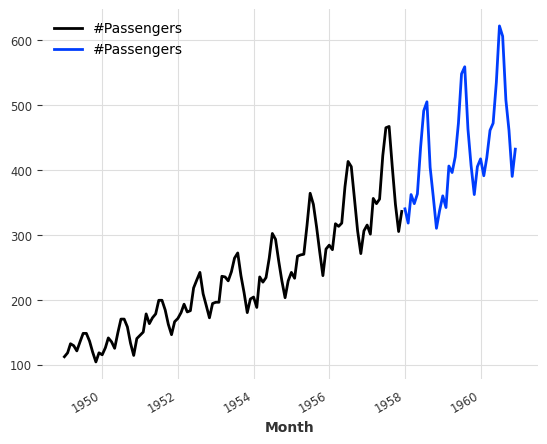

In [ ]:
#|eval: false
series1, series2 = series[:-36], series[-36:]
series1.plot()
series2.plot()

<Axes: xlabel='Month'>

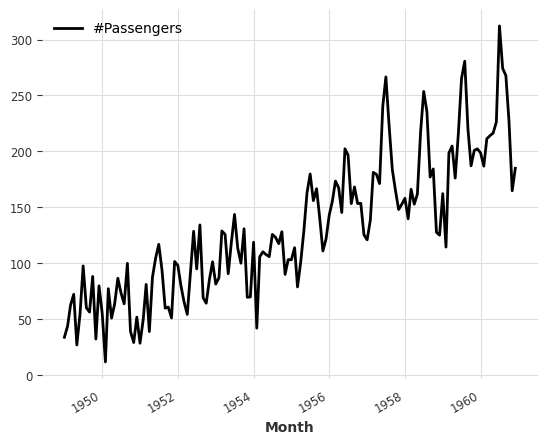

In [ ]:
#|eval: false
series_noise = TimeSeries.from_times_and_values(
    series.time_index, np.random.randn(len(series))
)
(series / 2 + 20 * series_noise - 10).plot()

<Axes: xlabel='Month'>

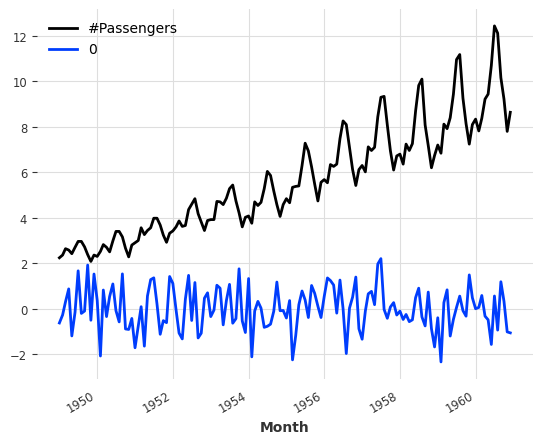

In [ ]:
#|eval: false
(series / 50).stack(series_noise).plot()

<Axes: xlabel='Month'>

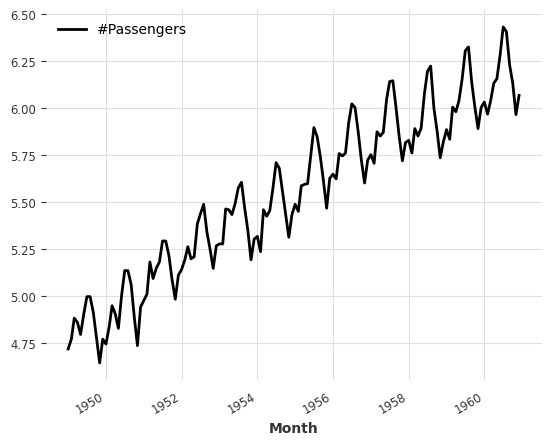

In [ ]:
#|eval: false
series.map(np.log).plot()

<Axes: xlabel='Month'>

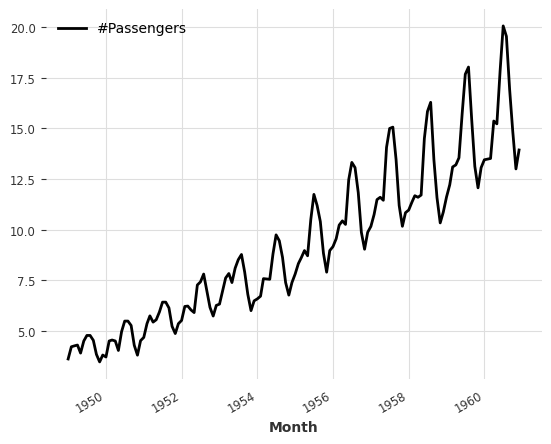

In [ ]:
#|eval: false
series.map(lambda ts, x: x / ts.days_in_month).plot()

<Axes: xlabel='Month'>

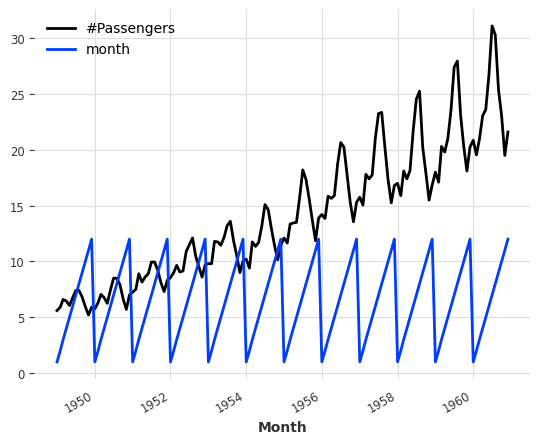

In [ ]:
#|eval: false
(series / 20).add_datetime_attribute("month").plot()

<Axes: xlabel='Month'>

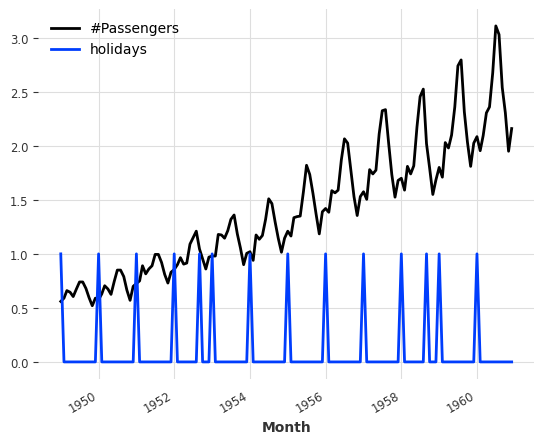

In [ ]:
#|eval: false
(series / 200).add_holidays("US").plot()

<Axes: xlabel='Month'>

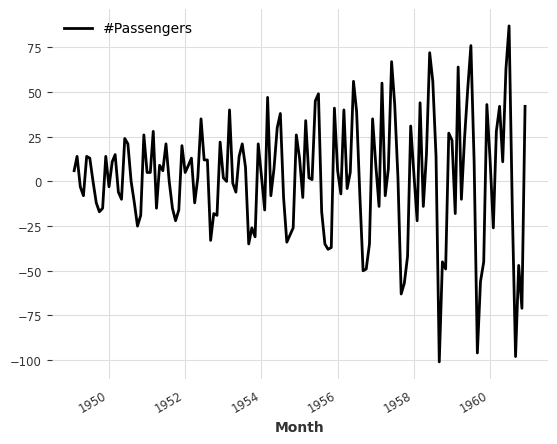

In [ ]:
#|eval: false
series.diff().plot()

In [ ]:
#|eval: false
from darts.utils.missing_values import fill_missing_values

<Axes: xlabel='time'>

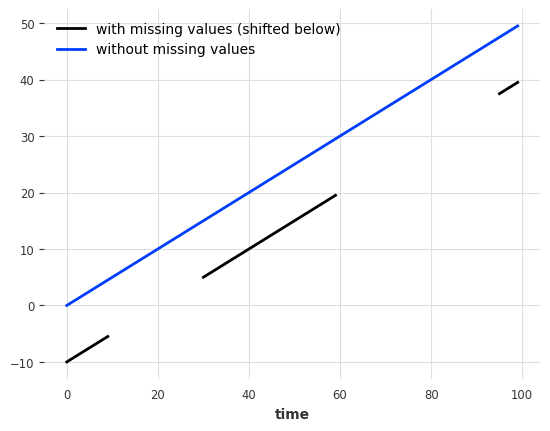

In [ ]:
#|eval: false
values = np.arange(50, step=0.5)
values[10:30] = np.nan
values[60:95] = np.nan
series_ = TimeSeries.from_values(values)

(series_ - 10).plot(label="with missing values (shifted below)")
fill_missing_values(series_).plot(label="without missing values")

<Axes: xlabel='Month'>

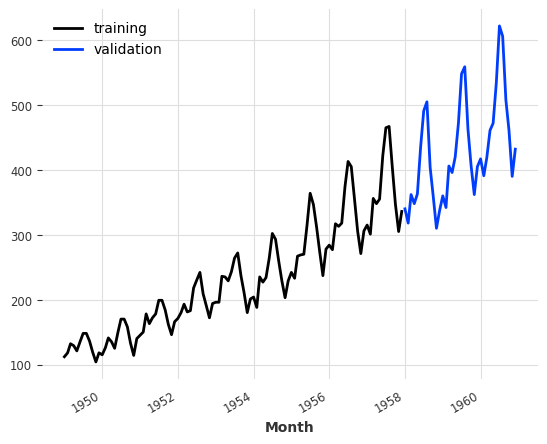

In [ ]:
#|eval: false
train, val = series.split_before(pd.Timestamp("19580101"))
train.plot(label="training")
val.plot(label="validation")

## Training forecasting models and making predictions

In [ ]:
#|eval: false
from darts.models import NaiveSeasonal

/home/thekkel/mambaforge/envs/cfast/lib/python3.11/site-packages/neptune/internal/backends/hosted_client.py:51: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
/home/thekkel/mambaforge/envs/cfast/lib/python3.11/site-packages/pytorch_lightning/loggers/neptune.py:51: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  import neptune.new as neptune


<Axes: xlabel='Month'>

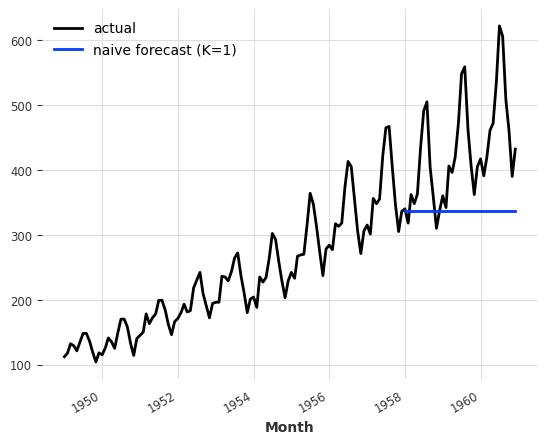

In [ ]:
#|eval: false
naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

## Inspect Seasonality

In [ ]:
#|eval: false
from darts.utils.statistics import plot_acf, check_seasonality

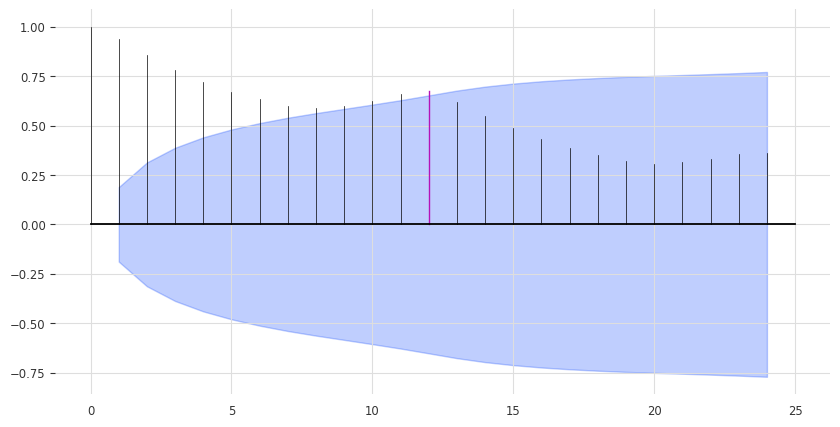

In [ ]:
#|eval: false
plot_acf(train, m=12, alpha=0.05)

In [ ]:
#|eval: false
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 12.


<Axes: xlabel='Month'>

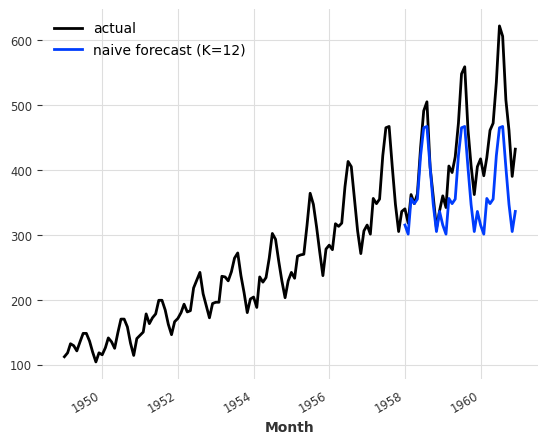

In [ ]:
#|eval: false
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

In [ ]:
#|eval: false
from darts.models import NaiveDrift

<Axes: xlabel='Month'>

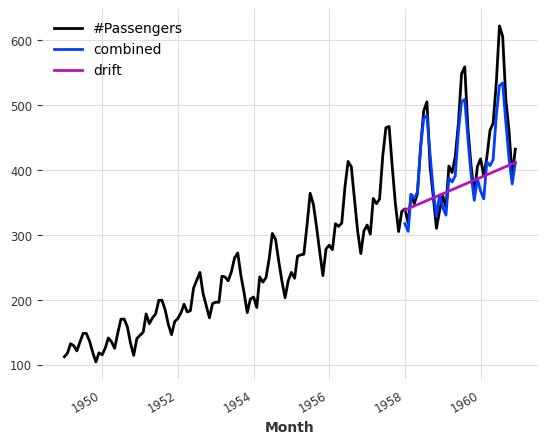

In [ ]:
#|eval: false
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [ ]:
#|eval: false
from darts.metrics import mape

In [ ]:
#|eval: false
print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        mape(series, combined_forecast)
    )
)

Mean absolute percentage error for the combined naive drift + seasonal: 5.66%.


In [ ]:
#|eval: false
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta

model ExponentialSmoothing() obtains MAPE: 5.11%
model TBATS() obtains MAPE: 5.87%
model AutoARIMA() obtains MAPE: 11.65%
model Theta() obtains MAPE: 8.15%


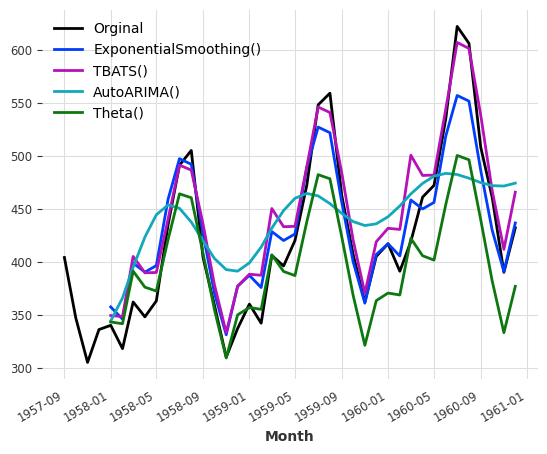

In [ ]:
#|eval: false
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))
    forecast.plot(label = str(model))

series[-40:].plot(label="Orginal")
eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

## Searching for hyper-parameters with the Theta method¶

In [ ]:
#|eval: false
# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

In [ ]:
#|eval: false
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(val, pred_best_theta), best_theta
    )
)

The MAPE is: 4.40, with theta = -3.5102040816326543.


<Axes: xlabel='Month'>

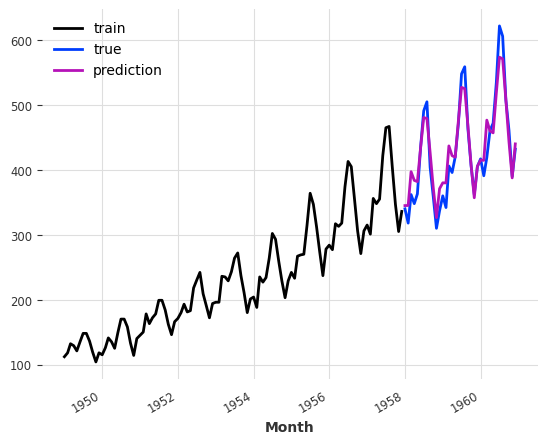

In [ ]:
#|eval: false
train.plot(label="train")
val.plot(label="true")
pred_best_theta.plot(label="prediction")

## Backtesting: simulate historical forecasting

  0%|          | 0/57 [00:00<?, ?it/s]

MAPE = 7.70%


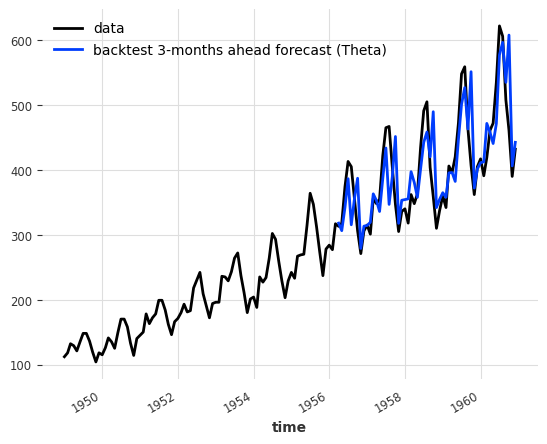

In [ ]:
#|eval: false
historical_fcast_theta = best_theta_model.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_theta.plot(label="backtest 3-months ahead forecast (Theta)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_theta, series)))

  0%|          | 0/57 [00:00<?, ?it/s]

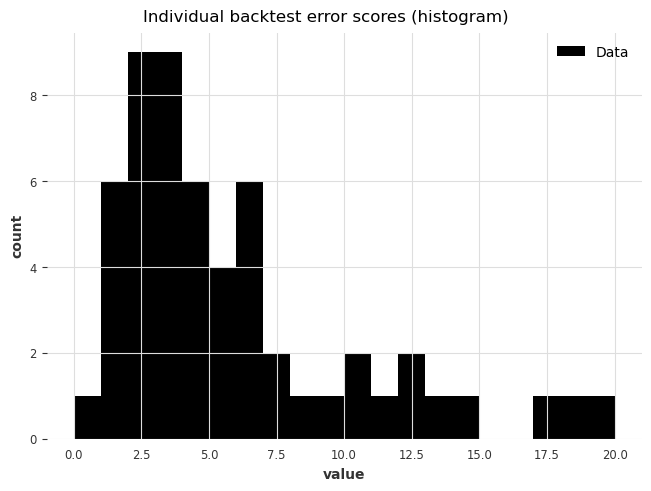

In [ ]:
#|eval: false
best_theta_model = Theta(best_theta)

raw_errors = best_theta_model.backtest(
    series, start=0.6, forecast_horizon=3, metric=mape, reduction=None, verbose=True
)

from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)

In [ ]:
#|eval: false
average_error = best_theta_model.backtest(
    series,
    start=0.6,
    forecast_horizon=3,
    metric=mape,
    reduction=np.mean,  # this is actually the default
    verbose=True,
)

print("Average error (MAPE) over all historical forecasts: %.2f" % average_error)

  0%|          | 0/57 [00:00<?, ?it/s]

Average error (MAPE) over all historical forecasts: 6.36


In [ ]:
#|eval: false
from darts.utils.statistics import plot_residuals_analysis

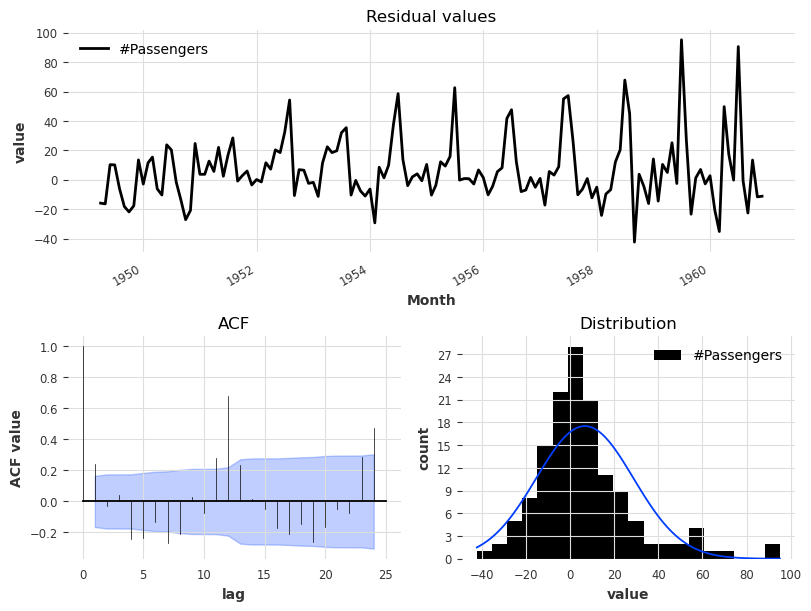

In [ ]:
#|eval: false
plot_residuals_analysis(best_theta_model.residuals(series))

  0%|          | 0/57 [00:00<?, ?it/s]

MAPE = 4.45%


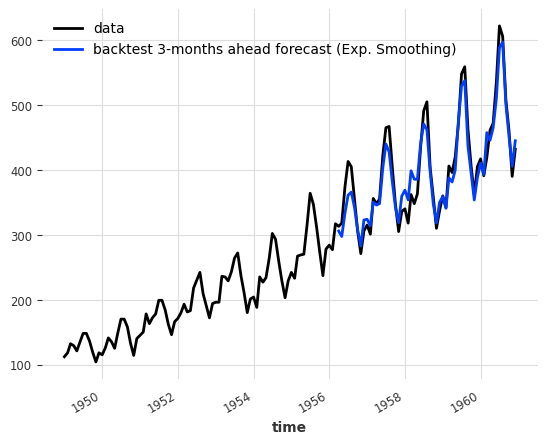

In [ ]:
#|eval: false
model_es = ExponentialSmoothing(seasonal_periods=12)
historical_fcast_es = model_es.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_es.plot(label="backtest 3-months ahead forecast (Exp. Smoothing)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_es, series)))

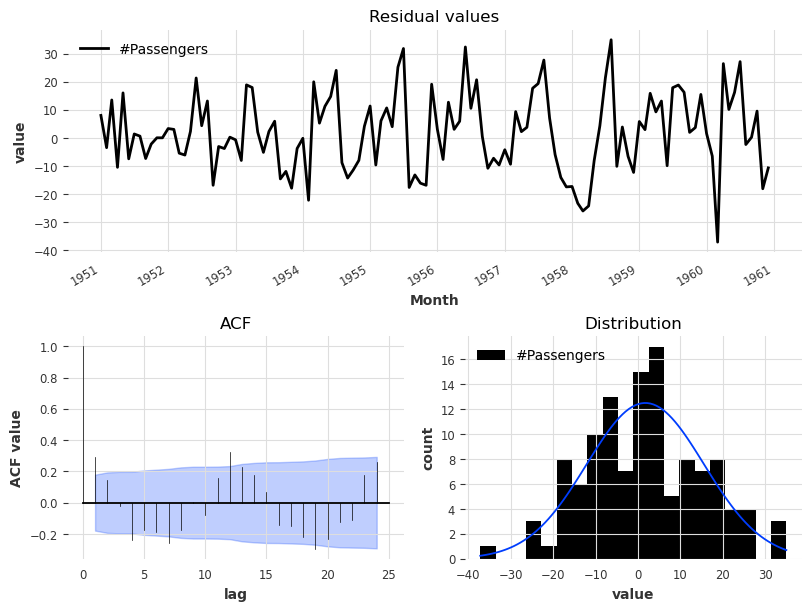

In [ ]:
#|eval: false
plot_residuals_analysis(model_es.residuals(series))

## Machine learning and global models

RegressionModel can wrap around any sklearn-compatible regression model to produce forecasts (it has its own section below).

RNNModel is a flexible RNN implementation, which can be used like DeepAR.

NBEATSModel implements the N-BEATS model.

TFTModel implements the Temporal Fusion Transformer model.

TCNModel implements temporal convolutional networks.

In [ ]:
#|eval: false
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

<Axes: xlabel='Month'>

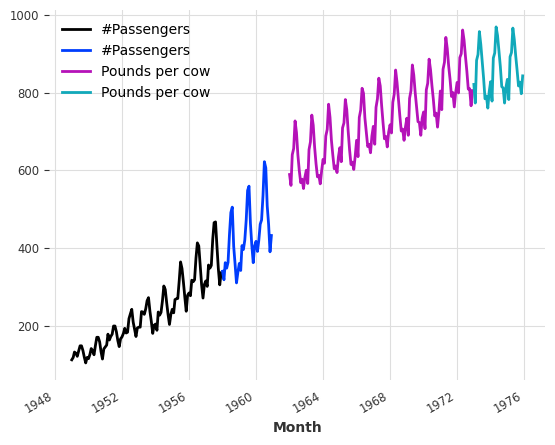

In [ ]:
#|eval: false
series_air = AirPassengersDataset().load().astype(np.float32)
series_milk = MonthlyMilkDataset().load().astype(np.float32)

# set aside last 36 months of each series as validation set:
train_air, val_air = series_air[:-36], series_air[-36:]
train_milk, val_milk = series_milk[:-36], series_milk[-36:]

train_air.plot()
val_air.plot()
train_milk.plot()
val_milk.plot()

In [ ]:
#|eval: false
from darts.dataprocessing.transformers import Scaler

<Axes: xlabel='Month'>

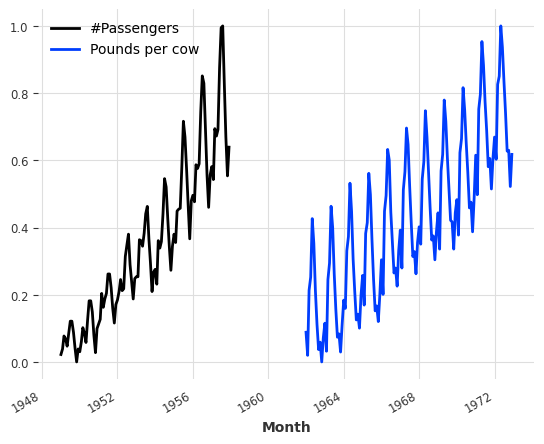

In [ ]:
#|eval: false
scaler = Scaler()
train_air_scaled, train_milk_scaled = scaler.fit_transform([train_air, train_milk])

train_air_scaled.plot()
train_milk_scaled.plot()

## Using deep learning: example with N-BEATS

In [ ]:
#|eval: false
from darts.models import NBEATSModel

In [ ]:
#|eval: false
model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit([train_air_scaled, train_milk_scaled], epochs=50, verbose=True);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated 

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

<Axes: xlabel='Month'>

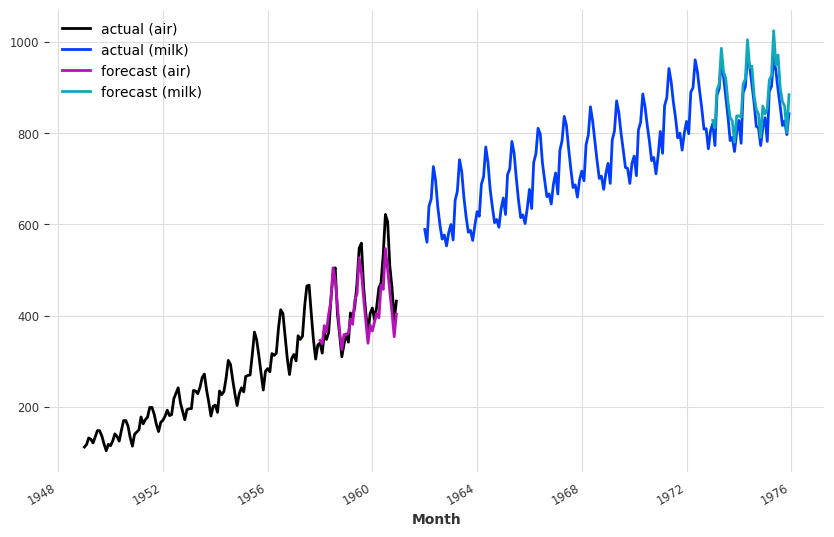

In [ ]:
#|eval: false
pred_air = model.predict(series=train_air_scaled, n=36)
pred_milk = model.predict(series=train_milk_scaled, n=36)

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

## Covariates: using external data

past_covariates are series not necessarily known ahead of the forecast time. Those can for instance represent things that have to be measured and are not known upfront. Models do not use the future values of past_covariates when making forecasts.

future_covariates are series which are known in advance, up to the forecast horizon. This can represent things such as calendar information, holidays, weather forecasts, etc. Models that accept future_covariates will look at the future values (up to the forecast horizon) when making forecasts.

In [ ]:
#|eval: false
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

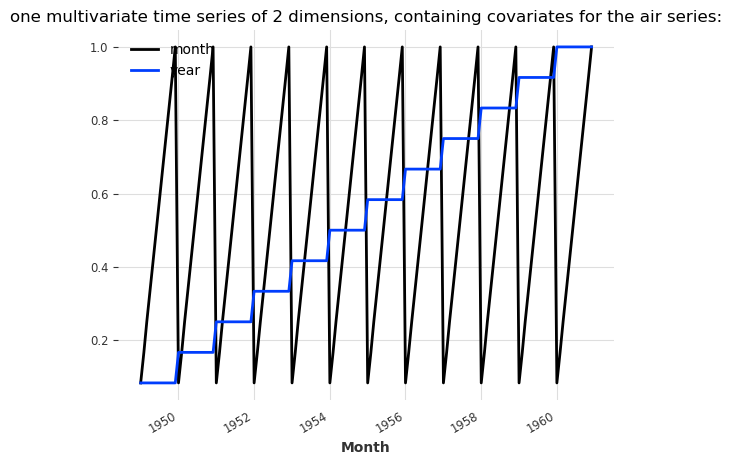

In [ ]:
#|eval: false
air_covs = concatenate(
    [
        dt_attr(series_air.time_index, "month", dtype=np.float32) / 12,
        (dt_attr(series_air.time_index, "year", dtype=np.float32) - 1948) / 12,
    ],
    axis="component",
)

milk_covs = concatenate(
    [
        dt_attr(series_milk.time_index, "month", dtype=np.float32) / 12,
        (dt_attr(series_milk.time_index, "year", dtype=np.float32) - 1962) / 13,
    ],
    axis="component",
)

air_covs.plot()
plt.title(
    "one multivariate time series of 2 dimensions, containing covariates for the air series:"
);

In [ ]:
#|eval: false
model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit(
    [train_air_scaled, train_milk_scaled],
    past_covariates=[air_covs, milk_covs],
    epochs=50,
    verbose=True,
);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.6 M 
---------------------------------------------------
6.6 M     Trainable params
1.7 K     Non-trainable params
6.6 M     Total params
26.314    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

<Axes: xlabel='Month'>

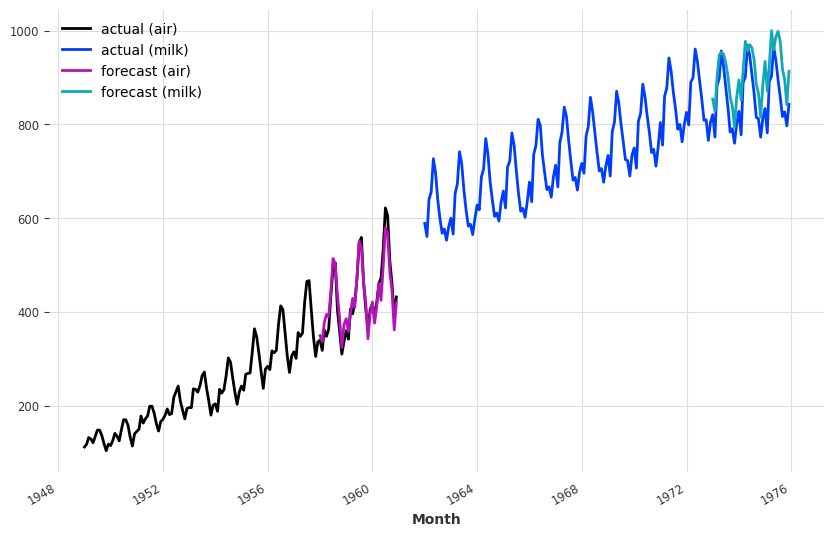

In [ ]:
#|eval: false
pred_air = model.predict(series=train_air_scaled, past_covariates=air_covs, n=36)
pred_milk = model.predict(series=train_milk_scaled, past_covariates=milk_covs, n=36)

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

## Encoders: using covariates for free

In [ ]:
#|eval: false
def extract_year(idx):
    """Extract the year each time index entry and normalized it."""
    return (idx.year - 1950) / 50


encoders = {
    "cyclic": {"future": ["month"]},
    "datetime_attribute": {"future": ["hour", "dayofweek"]},
    "position": {"past": ["absolute"], "future": ["relative"]},
    "custom": {"past": [extract_year]},
    "transformer": Scaler(),
}

In [ ]:
#|eval: false
encoders = {"datetime_attribute": {"past": ["month", "year"]}, "transformer": Scaler()}

In [ ]:
#|eval: false
model = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    add_encoders=encoders,
    random_state=42,
)

model.fit([train_air_scaled, train_milk_scaled], epochs=50, verbose=True);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.6 M 
---------------------------------------------------
6.6 M     Trainable params
1.7 K     Non-trainable params
6.6 M     Total params
26.314    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

<Axes: xlabel='Month'>

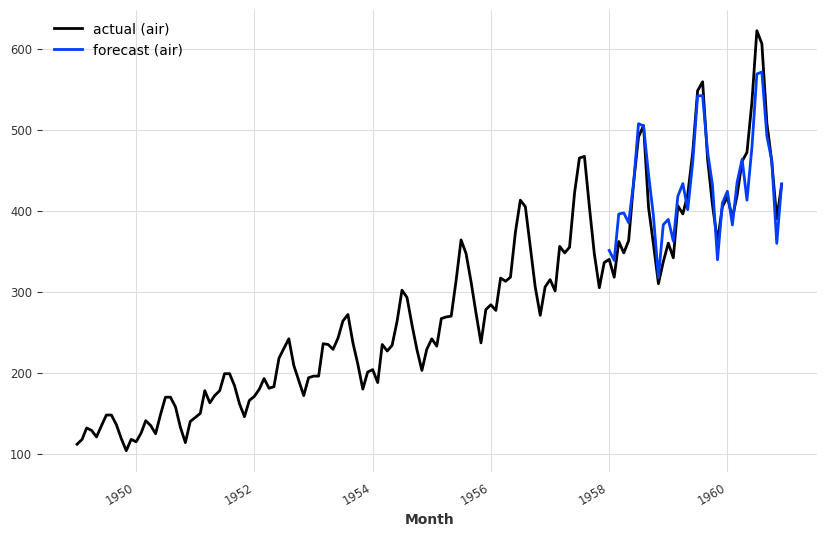

In [ ]:
#|eval: false
pred_air = model.predict(series=train_air_scaled, n=36)

# scale back:
pred_air = scaler.inverse_transform(pred_air)

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
pred_air.plot(label="forecast (air)")

## Regression forecasting models

In [ ]:
#|eval: false
from darts.models import RegressionModel
from sklearn.linear_model import BayesianRidge

In [ ]:
#|eval: false
model = RegressionModel(lags=72, lags_future_covariates=[-6, 0], model=BayesianRidge())

model.fit(
    [train_air_scaled, train_milk_scaled], future_covariates=[air_covs, milk_covs]
);

<Axes: xlabel='Month'>

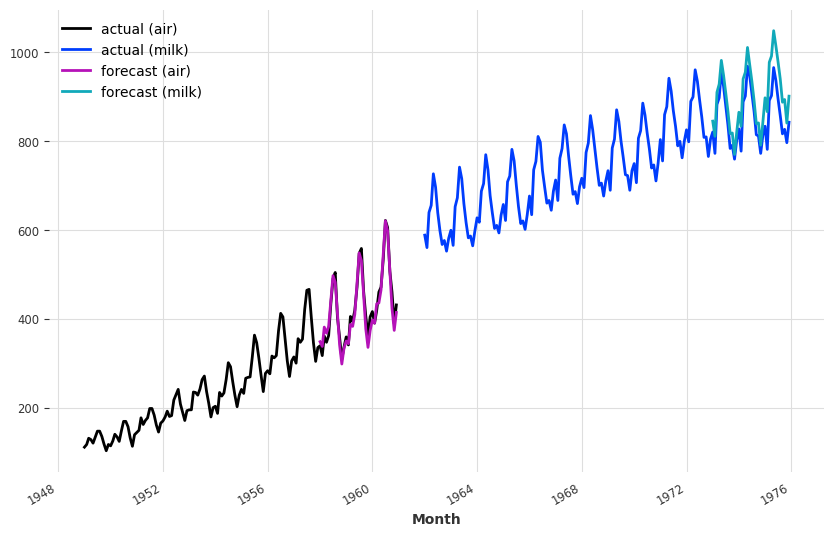

In [ ]:
#|eval: false
pred_air, pred_milk = model.predict(
    series=[train_air_scaled, train_milk_scaled],
    future_covariates=[air_covs, milk_covs],
    n=36,
)

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")

In [ ]:
#|eval: false
mape([series_air, series_milk], [pred_air, pred_milk])

[3.417016565799713, 5.283146351575851]

In [ ]:
#|eval: false
mape([series_air, series_milk], [pred_air, pred_milk], inter_reduction=np.mean)

4.350081458687782

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/57 [00:00<?, ?it/s]

MAPE = 3.66


<Axes: xlabel='time'>

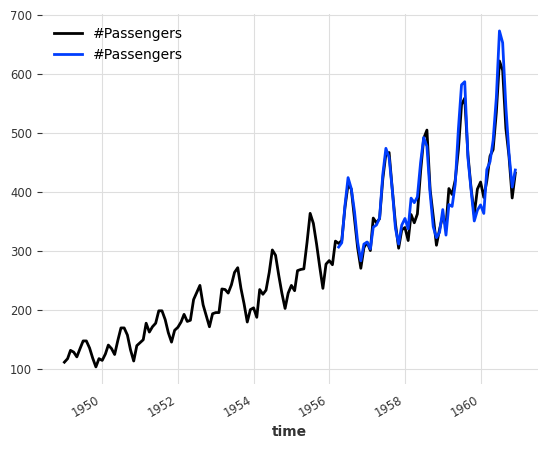

In [ ]:
#|eval: false
bayes_ridge_model = RegressionModel(
    lags=72, lags_future_covariates=[0], model=BayesianRidge()
)

backtest = bayes_ridge_model.historical_forecasts(
    series_air, future_covariates=air_covs, start=0.6, forecast_horizon=3, verbose=True
)

print("MAPE = %.2f" % (mape(backtest, series_air)))
series_air.plot()
backtest.plot()

## Probabilistic forecasts

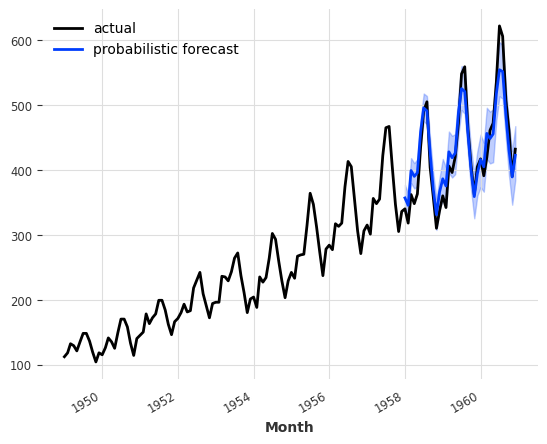

In [ ]:
#|eval: false
model_es = ExponentialSmoothing()
model_es.fit(train)
probabilistic_forecast = model_es.predict(len(val), num_samples=500)

series.plot(label="actual")
probabilistic_forecast.plot(label="probabilistic forecast")
plt.legend()
plt.show()

## With neural networks

In [ ]:
#|eval: false
from darts.models import TCNModel
from darts.utils.likelihood_models import LaplaceLikelihood

In [ ]:
#|eval: false
model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=42,
    likelihood=LaplaceLikelihood(),
)

model.fit(train_air_scaled, epochs=400, verbose=True);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 166   
----------------------------------------------------
166       Trainable params
0         Non-trainable params
166       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

<Axes: xlabel='Month'>

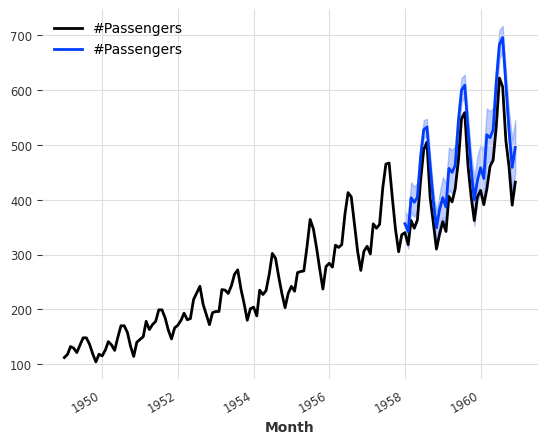

In [ ]:
#|eval: false
pred = model.predict(n=36, num_samples=500)

# scale back:
pred = scaler.inverse_transform(pred)

series_air.plot()
pred.plot()

In [ ]:
#|eval: false
model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=42,
    likelihood=LaplaceLikelihood(prior_b=0.1),
)

model.fit(train_air_scaled, epochs=400, verbose=True);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 166   
----------------------------------------------------
166       Trainable params
0         Non-trainable params
166       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

<Axes: xlabel='Month'>

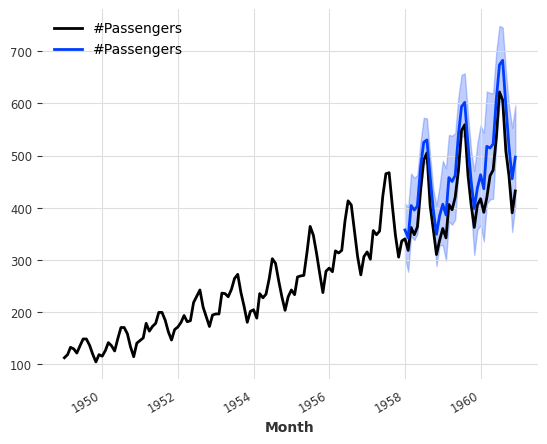

In [ ]:
#|eval: false
pred = model.predict(n=36, num_samples=500)

# scale back:
pred = scaler.inverse_transform(pred)

series_air.plot()
pred.plot()

<Axes: xlabel='Month'>

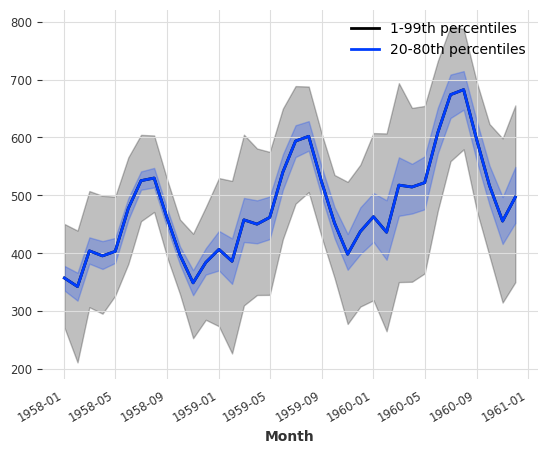

In [ ]:
#|eval: false
pred.plot(low_quantile=0.01, high_quantile=0.99, label="1-99th percentiles")
pred.plot(low_quantile=0.2, high_quantile=0.8, label="20-80th percentiles")

## Types of distributions

The likelihood has to be compatible with the domain of your time series’ values. For instance PoissonLikelihood can be used on discrete positive values, ExponentialLikelihood can be used on real positive values, and BetaLikelihood on real values in (0,1)

It is also possible to use QuantileRegression to apply a quantile loss and fit some desired quantiles directly.

## Evaluating Probabilistic Forecasts

In [ ]:
#|eval: false
from darts.metrics import rho_risk

In [ ]:
#|eval: false
print("MAPE of median forecast: %.2f" % mape(series_air, pred))
for rho in [0.05, 0.1, 0.5, 0.9, 0.95]:
    rr = rho_risk(series_air, pred, rho=rho)
    print("rho-risk at quantile %.2f: %.2f" % (rho, rr))

MAPE of median forecast: 11.67
rho-risk at quantile 0.05: 0.14
rho-risk at quantile 0.10: 0.14
rho-risk at quantile 0.50: 0.12
rho-risk at quantile 0.90: 0.03
rho-risk at quantile 0.95: 0.02


## Using Quantile Loss

In [ ]:
#|eval: false
from darts.utils.likelihood_models import QuantileRegression

In [ ]:
#|eval: false
model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=42,
    likelihood=QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95]),
)

model.fit(train_air_scaled, epochs=400, verbose=True);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 208   
----------------------------------------------------
208       Trainable params
0         Non-trainable params
208       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

MAPE of median forecast: 5.11
rho-risk at quantile 0.05: 0.00
rho-risk at quantile 0.10: 0.00
rho-risk at quantile 0.50: 0.02
rho-risk at quantile 0.90: 0.01
rho-risk at quantile 0.95: 0.01


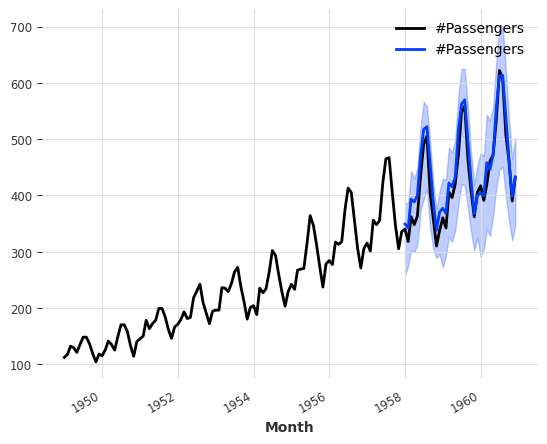

In [ ]:
#|eval: false
pred = model.predict(n=36, num_samples=500)

# scale back:
pred = scaler.inverse_transform(pred)

series_air.plot()
pred.plot()

print("MAPE of median forecast: %.2f" % mape(series_air, pred))
for rho in [0.05, 0.1, 0.5, 0.9, 0.95]:
    rr = rho_risk(series_air, pred, rho=rho)
    print("rho-risk at quantile %.2f: %.2f" % (rho, rr))

## Ensembling models

Ensembling is about combining the forecasts produced by several models, in order to obtain a final - and hopefully better forecast.

For instance, in our example of a less naive model above, we manually combined a naive seasonal model with a naive drift model. Here, we will show how models forecasts can be automatically combined, naively using a NaiveEnsembleModel, or learned using RegressionEnsembleModel.

It is of course also possible to use past and/or future_covariates with ensemble model but they will be passed only to the models supporting them when calling fit() and predict().

## Naive Ensembling

In [ ]:
#|eval: false
from darts.models import NaiveEnsembleModel

  0%|          | 0/57 [00:00<?, ?it/s]

MAPE = 11.88


<Axes: xlabel='time'>

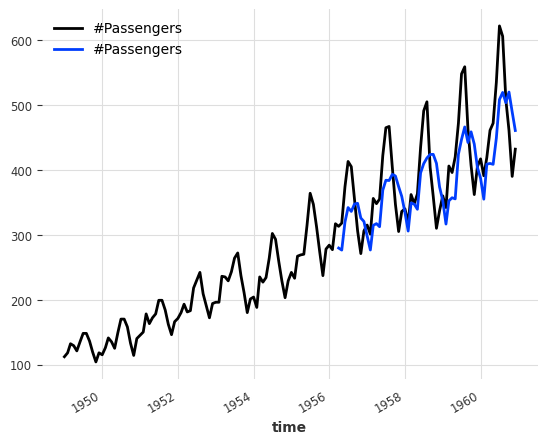

In [ ]:
#|eval: false
models = [NaiveDrift(), NaiveSeasonal(12)]

ensemble_model = NaiveEnsembleModel(forecasting_models=models)

backtest = ensemble_model.historical_forecasts(
    series_air, start=0.6, forecast_horizon=3, verbose=True
)

print("MAPE = %.2f" % (mape(backtest, series_air)))
series_air.plot()
backtest.plot()

## Learned Ensembling

As expected in this case, the naive ensemble doesn’t give great results (although in some cases it could!)

We can sometimes do better if we see the ensembling as a supervised regression problem: given a set of forecasts (features), find a model that combines them in order to minimise errors on the target. This is what the RegressionEnsembleModel does. It accepts three parameters:

    forecasting_models is a list of forecasting models whose predictions we want to ensemble.

    regression_train_n_points is the number of time steps to use for fitting the “ensemble regression” model (i.e., the inner model that combines the forecasts).

    regression_model is, optionally, a sklearn-compatible regression model or a Darts RegressionModel to be used for the ensemble regression. If not specified, a linear regression is used. Using a sklearn model is easy out-of-the-box, but using a RegressionModel allows to potentially take arbitrary lags of the individual forecasts as inputs of the regression model.

Once these elements are in place, a RegressionEnsembleModel can be used like a regular forecasting model:

In [ ]:
#|eval: false
from darts.models import RegressionEnsembleModel

  0%|          | 0/57 [00:00<?, ?it/s]

MAPE = 4.85


<Axes: xlabel='time'>

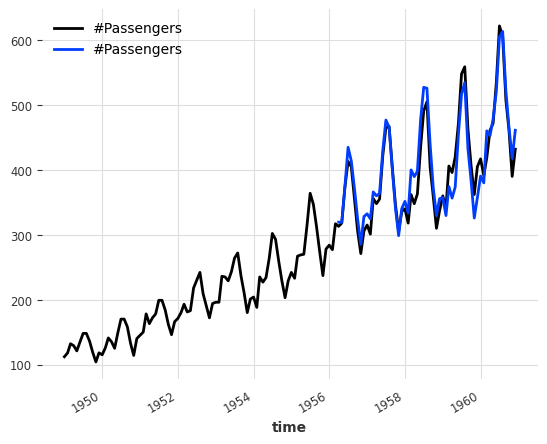

In [ ]:
#|eval: false
models = [NaiveDrift(), NaiveSeasonal(12)]

ensemble_model = RegressionEnsembleModel(
    forecasting_models=models, regression_train_n_points=12
)

backtest = ensemble_model.historical_forecasts(
    series_air, start=0.6, forecast_horizon=3, verbose=True
)

print("MAPE = %.2f" % (mape(backtest, series_air)))
series_air.plot()
backtest.plot()

In [ ]:
#|eval: false
ensemble_model.fit(series_air)
ensemble_model.regression_model.model.coef_#|eval: false

array([0.0136882, 1.0980103], dtype=float32)

In [ ]:
#|eval: false
from darts.models import LinearRegressionModel

  0%|          | 0/57 [00:00<?, ?it/s]

MAPE = 4.79


<Axes: xlabel='time'>

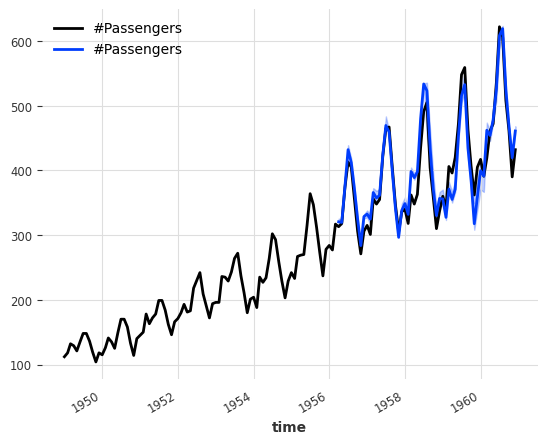

In [ ]:
#|eval: false
quantiles = [0.25, 0.5, 0.75]

models = [NaiveDrift(), NaiveSeasonal(12)]

regression_model = LinearRegressionModel(
    quantiles=quantiles,
    lags_future_covariates=[0],
    likelihood="quantile",
    fit_intercept=False,
)

ensemble_model = RegressionEnsembleModel(
    forecasting_models=models,
    regression_train_n_points=12,
    regression_model=regression_model,
)

backtest = ensemble_model.historical_forecasts(
    series_air, start=0.6, forecast_horizon=3, num_samples=500, verbose=True
)

print("MAPE = %.2f" % (mape(backtest, series_air)))
series_air.plot()
backtest.plot()

## Fitting a Kalman Filter

In [ ]:
#|eval: false
from darts.models import KalmanFilter

<Axes: xlabel='Month'>

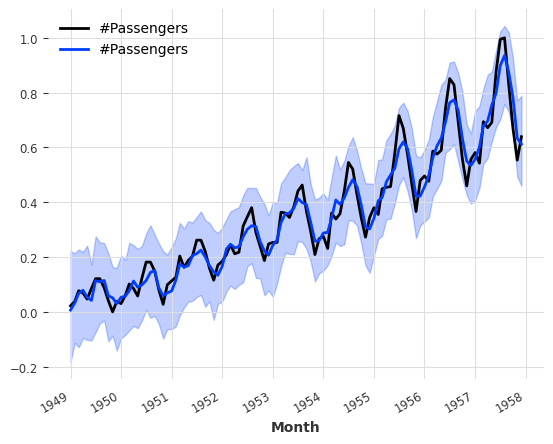

In [ ]:
#|eval: false
kf = KalmanFilter(dim_x=3)
kf.fit(train_air_scaled)
filtered_series = kf.filter(train_air_scaled, num_samples=100)

train_air_scaled.plot()
filtered_series.plot(#|eval: false
)

## Inferring missing values with Gaussian Processes

In [ ]:
#|eval: false
from darts.models import GaussianProcessFilter
from sklearn.gaussian_process.kernels import RBF

<Axes: xlabel='Month'>

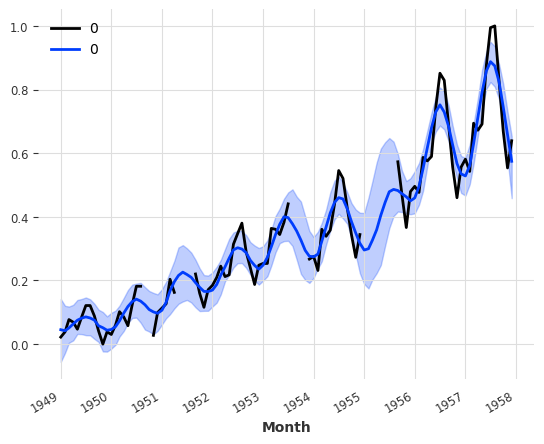

In [ ]:
#|eval: false
# create a series with holes:
values = train_air_scaled.values()
values[20:22] = np.nan
values[28:32] = np.nan
values[55:59] = np.nan
values[72:80] = np.nan
series_holes = TimeSeries.from_times_and_values(train_air_scaled.time_index, values)
series_holes.plot()

kernel = RBF()

gpf = GaussianProcessFilter(kernel=kernel, alpha=0.1, normalize_y=True)
filtered_series = gpf.filter(series_holes, num_samples=100)

filtered_series.plot()